# Cell clustering notebook

Note: this notebook should be run after `example_pixel_clustering.ipynb` in the same Docker session

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

## 1: Load parameters for cell clustering (computed by pixel_clustering)

The file name should be in the form `{cluster_prefix_from_pixel_clustering}_cell_clustering_params.json`. Make sure to set `base_dir` to the same value used in `example_pixel_clustering.ipynb`.

The following params are loaded:

* `fovs`: the set of fovs
* `channels`: the subset of markers
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb). Should be set to the same value as `base_dir` in `example_pixel_clustering.ipynb`
* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments
* `pc_chan_avg_cluster_name`: the name of the file containing the average marker channel expression per pixel SOM cluster, used for the visualization of weighted channel average per cell
* `pc_chan_avg_hCluster_cap_name`: the name of the file containing the average marker channel expression per pixel meta cluster, used for the visualization of weighted channel average per cell

In [ ]:
# define the base dir
base_dir = "../data/granulomaCohort_allData"

# change the prefix of cell_clustering_params_name accordingly
cell_clustering_params_name = 'test_cell_clustering_params.json'

In [ ]:
# load the params
with open(os.path.join(base_dir, cell_clustering_params_name)) as fh:
    cell_clustering_params = json.load(fh)
    
# assign the params to variables
fovs = cell_clustering_params['fovs']
channels = cell_clustering_params['channels']
segmentation_dir = cell_clustering_params['segmentation_dir']
pixel_consensus_dir = cell_clustering_params['pixel_consensus_dir']
pc_chan_avg_cluster_name = cell_clustering_params['pc_chan_avg_cluster_name']
pc_chan_avg_hCluster_cap_name = cell_clustering_params['pc_chan_avg_hCluster_cap_name']

* `cell_table_name`: name of the cell table created by `Segment_Image_Data.ipynb`, should be placed in the root of `base_dir`. You can use either the normalized or arcsinh versions.

In [ ]:
cell_table_name = 'cell_table_size_normalized.csv'

## 2: Cell clustering

### 2.1: train cell SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `{cluster_prefix}_cell_clustered_name`: file to store cell data with just the SOM cluster assignments
* `{cluster_prefix}_cell_consensus_dir`: directory to store cell data with the SOM and consensus cluster assignments
* `{cluster_prefix}_cell_weights_name`: file name to place the cell SOM weights

In [ ]:
# explicitly set cluster_prefix to override datetime default
cluster_prefix = None

if cluster_prefix is None:
    cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')
    
# define the cell SOM cluster and cell SOM weights paths, explicitly set the variables to use custom names
cell_clustered_name = '%s_cell_mat_clustered.feather' % cluster_prefix
cell_consensus_name = '%s_cell_mat_consensus.feather' % cluster_prefix
cell_weights_name = '%s_cell_weights.feather' % cluster_prefix

* `cluster_col`: whether to use pixel SOM or meta cluster counts for training. Set to 'cluster' or 'hCluster_cap' respectively.

In [ ]:
cluster_col = 'hCluster_cap'

For a full set of parameters you can customize for train_cell_som, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_cell_som>cell training docs</a>

In [ ]:
# create the cell-level SOM weights
som_utils.train_cell_som(
    fovs,
    base_dir,
    cell_table_name=cell_table_name,
    pixel_consensus_dir=pixel_consensus_dir,
    weights_name=cell_weights_name,
    cluster_col=cluster_col,
    num_passes=10
)

### 2.2: assign cell SOM clusters

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(
    base_dir,
    weights_name=cell_weights_name,
    cell_cluster_name=cell_clustered_name,
)

### 2.3: weight the channel expression values in the cell table (based on selected pixel cluster_col)

* See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>
* The weighted cell channel average result will be used for consensus clustering and interactive reclustering
* Results are saved as `weighted_cell_channel_avg.feather`

In [ ]:
# read in the cluster channel average table (computed by example_pixel_clustering.ipynb)
if cluster_col == 'cluster':
    pixel_cluster_channel_avg = pd.read_csv(os.path.join(base_dir, pc_chan_avg_cluster_name))
elif cluster_col == 'hCluster_cap':
    pixel_cluster_channel_avg = pd.read_csv(os.path.join(base_dir, pc_chan_avg_hCluster_cap_name))

In [ ]:
# read in the pixel SOM cluster counts per cell table (created by train_cell_som)
pixel_cluster_counts_per_cell = feather.read_dataframe(os.path.join(base_dir, 'cluster_counts.feather'))

In [ ]:
# compute the weighted channel avg
weighted_cell_channel_avg = som_utils.compute_p2c_weighted_channel_avg(
    pixel_cluster_channel_avg, pixel_cluster_counts_per_cell, fovs=fovs, cluster_col=cluster_col
)

# save to CSV for later use
weighted_cell_channel_avg.to_csv(os.path.join(base_dir, 'weighted_cell_channel_avg.csv'))

### 2.4: compute average number of pixel SOM/meta clusters and number of cells per cell SOM cluster

Note:

* This table will be used in cell consensus clustering and interactive reclustering
* Data is saved as `cell_cluster_avgs.feather`
* After consensus clustering, meta cluster assignments will be added to the table and data will be resaved

In [ ]:
# compute the average pixel SOM/meta counts per cell SOM cluster
cell_cluster_avgs_and_counts = som_utils.compute_cell_cluster_count_avg(
    os.path.join(base_dir, cell_clustered_name),
    cluster_col,
    'cluster',
    keep_count=True
)

In [ ]:
# save count averages
cell_cluster_avgs_and_counts.to_csv(os.path.join(base_dir, 'cell_cluster_avgs.csv'))

### 2.5: run cell consensus clustering

For a full set of parameters you can customize for cell_consensus_cluster, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.cell_consensus_cluster>cell consensus clustering docs</a>

In [ ]:
# define the subset of cluster cols, always prefixed by 'cluster_' or 'hCluster_cap_'
cluster_cols = [c for c in cell_cluster_avgs_and_counts if c.startswith(cluster_col + '_')]

In [ ]:
# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    base_dir=base_dir,
    cluster_cols=cluster_cols,
    cell_cluster_name=cell_clustered_name,
    cell_consensus_name=cell_consensus_name
)

### 2.6: compute weighted channel average per cell SOM cluster (z-scored)

Note:

* This is used in interactive reclustering
* Cell meta cluster labels will be mapped
* Data will be saved as `cell_cluster_channel_avg.feather` after meta cluster assignments are added

In [ ]:
# read in the clust_to_meta_name file
clust_to_meta_data = feather.read_dataframe(os.path.join(base_dir, 'cell_clust_to_meta.feather')).astype(np.int64)

In [ ]:
# compute the weighted channel average expression per cell SOM cluster
cell_cluster_channel_avg = som_utils.compute_cell_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    weighted_cell_channel_avg,
    cell_clustered_name,
    'cluster'
)

In [ ]:
# map the meta cluster labels to the weighted channel average data by cell SOM cluster
cell_cluster_channel_avg = pd.merge_asof(
    cell_cluster_channel_avg, clust_to_meta_data, on='cluster'
)

In [ ]:
# save weighted channel expression
cell_cluster_channel_avg.to_csv(os.path.join(base_dir, 'cell_cluster_channel_avg.csv'), index=False)

### 2.7: add meta cluster labels to pixel SOM/meta cluster counts per cell SOM cluster table

Note:

* This is needed for interactive reclustering
* Data from section 2.4 is resaved to `cell_cluster_avgs.feather` (same data but with meta cluster assignment column included)

In [ ]:
# map the meta cluster labels to cell SOM cluster counts table
cell_cluster_avgs_and_counts = pd.merge_asof(
    cell_cluster_avgs_and_counts, clust_to_meta_data, on='cluster'
)

In [ ]:
# save count data
cell_cluster_avgs_and_counts.to_csv(os.path.join(base_dir, 'cell_cluster_avgs.csv'), index=False)

### 2.8: compute weighted channel average per cell meta cluster (z-scored)

Note:

* This is used in visualizing weighted channel expression per cell meta cluster and interactive reclustering
* Data is saved as cell_hCluster_cap_channel_avg.feather

In [ ]:
# compute the weighted average channel expression per cell meta cluster
cell_hCluster_cap_channel_avg = som_utils.compute_cell_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    weighted_cell_channel_avg,
    cell_consensus_name,
    'hCluster_cap'
)

In [ ]:
# save average channel expression
cell_hCluster_cap_channel_avg.to_csv(os.path.join(base_dir, 'cell_hCluster_cap_channel_avg.csv'), index=False)

### 2.9: compute average number of pixel SOM/meta clusters and number of cells per cell meta cluster

Note:

* This is needed for heatmap visualization and interactive reclustering
* Data is saved as `cell_hCluster_cap_avgs.feather`

In [ ]:
# compute the average pixel SOM/meta counts per cell meta cluster
cell_hCluster_cap_avgs_and_counts = som_utils.compute_cell_cluster_count_avg(
    os.path.join(base_dir, cell_consensus_name),
    cluster_col,
    'hCluster_cap',
    keep_count=True
)

In [ ]:
# save count averages
cell_hCluster_cap_avgs_and_counts.to_csv(os.path.join(base_dir, 'cell_hCluster_cap_avgs.csv'), index=False)

## 3: visualize results

### 3.1: number of cells per SOM cluster

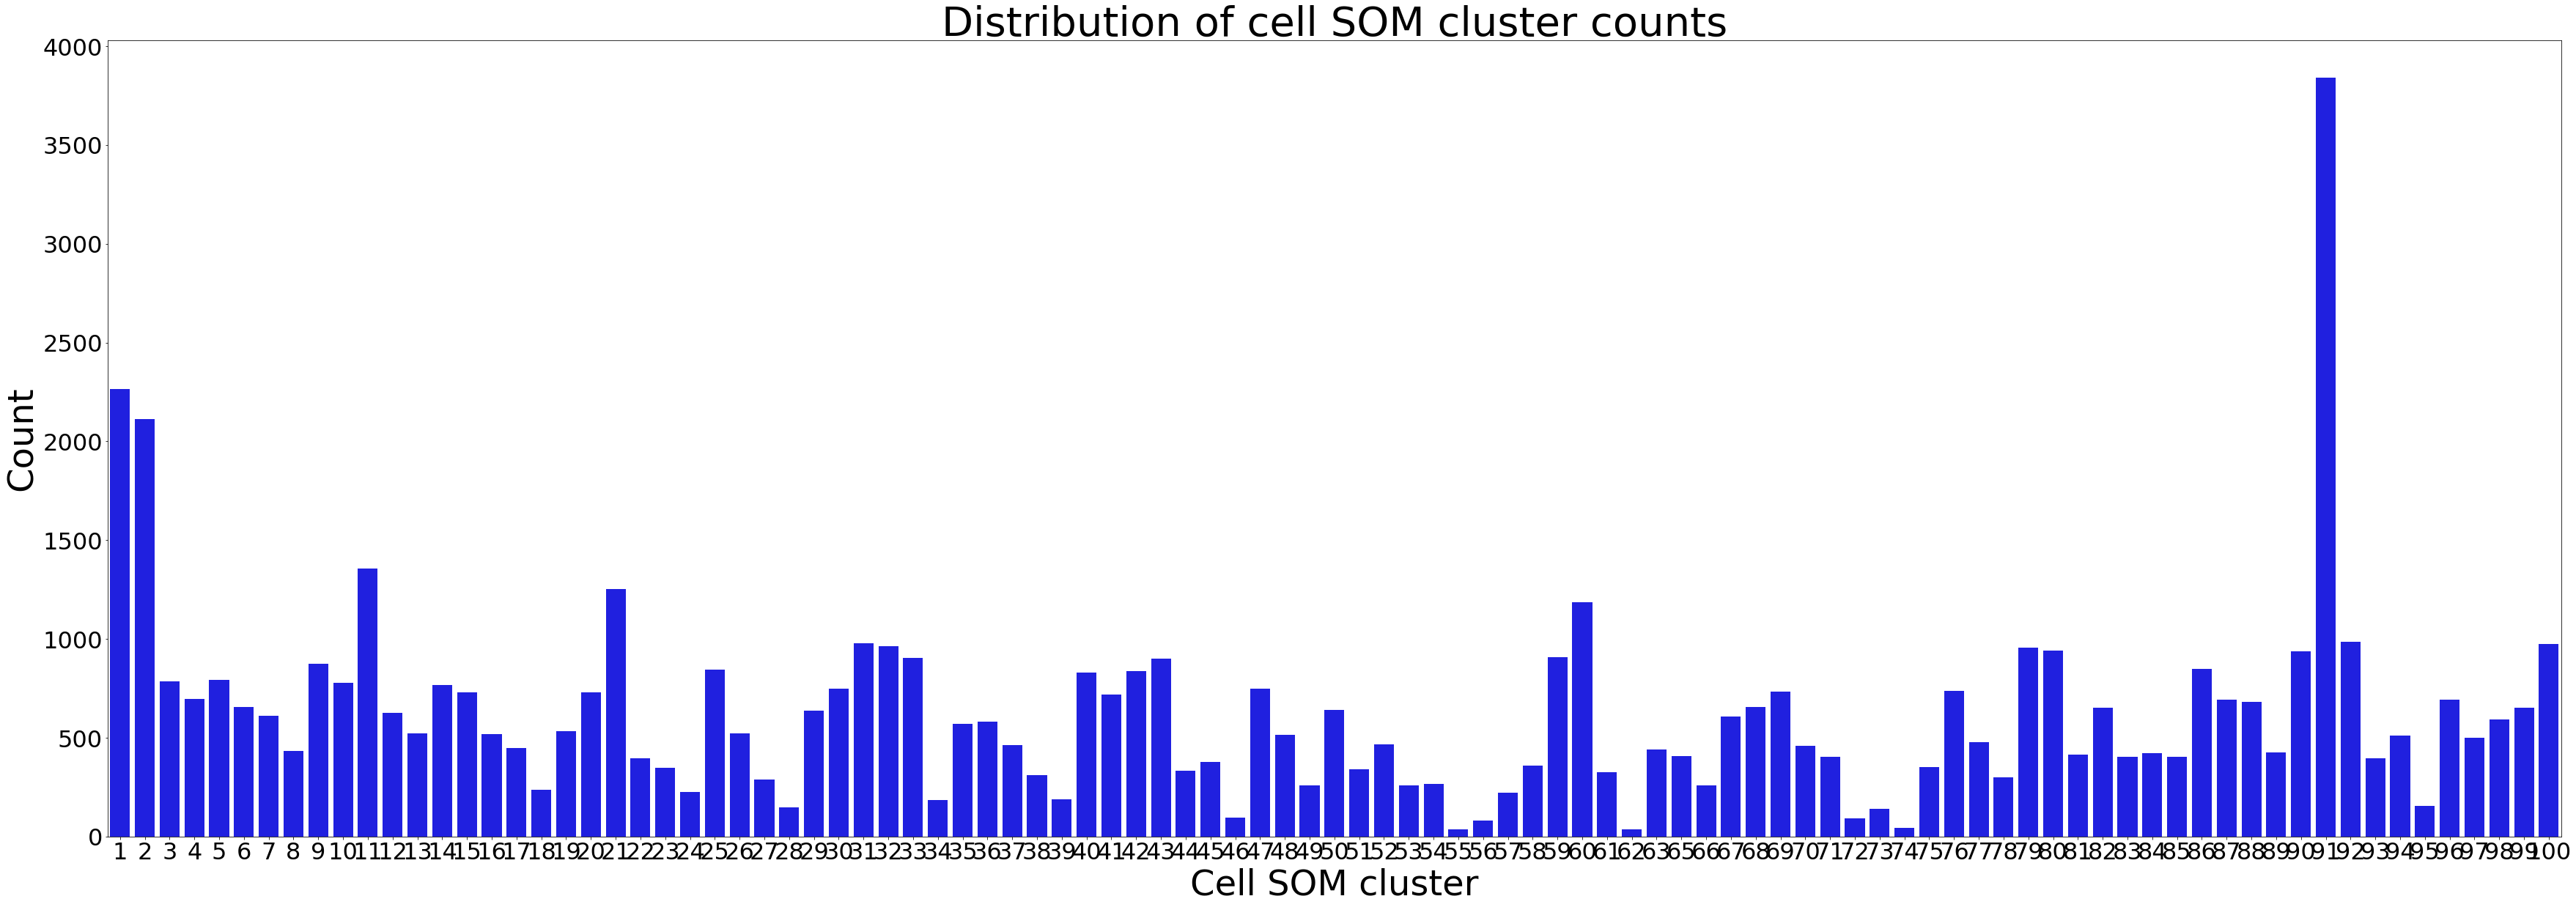

In [26]:
# visualize the cell counts per SOM cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(
    x=cell_cluster_avgs_and_counts['cluster'],
    y=cell_cluster_avgs_and_counts['count'],
    palette=['#0000FF' for i in range(cell_cluster_avgs_and_counts.shape[0])]
)
_ = plt.title('Distribution of cell SOM cluster counts', fontsize=56)
_ = plt.xlabel('Cell SOM cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### 3.2: weighted cell SOM cluster average heatmap over channels (z-scored)

* See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>
* The weighted cell channel average result will also be used for interactive reclustering
* Results are also saved as `cell_channel_avg_cluster.feather` and `cell_channel_avg_hCluster_cap` in `base_dir`

In [ ]:
# define the colormap
hCluster_cap_labels = cell_cluster_channel_avg['hCluster_cap'].unique()
color_palette = sns.color_palette("hls", len(hCluster_cap_labels))
colormap = dict(zip(hCluster_cap_labels, color_palette))

# map the values, then reindex based on cluster values
cluster_index = cell_cluster_channel_avg['cluster'].values
hCluster_cap_mapping = pd.Series(cell_cluster_channel_avg['hCluster_cap']).map(colormap)
hCluster_cap_mapping.index = cluster_index

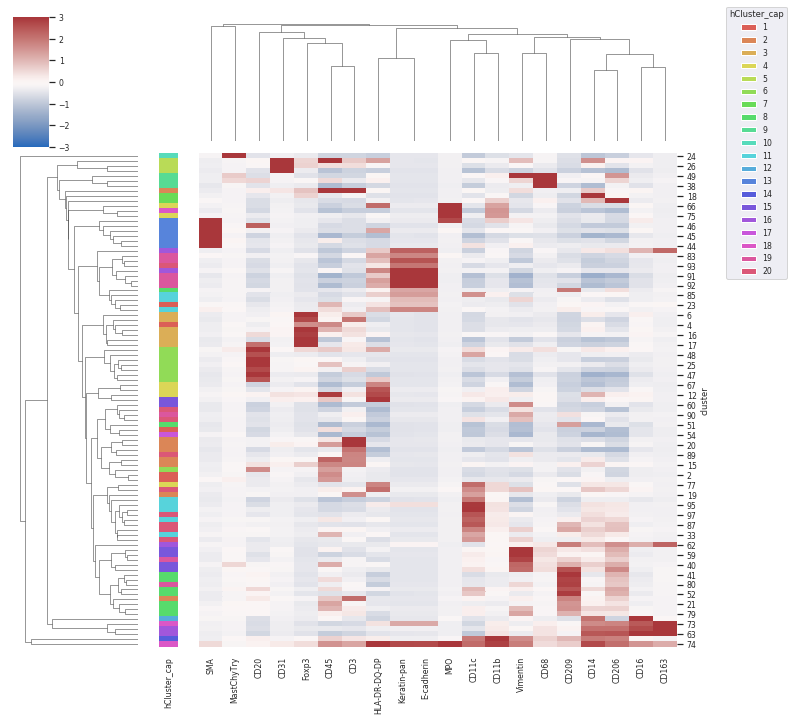

In [28]:
# using weighted average discretizes values better since we take advantage of pixel cluster info
visualize.draw_heatmap(
    data=cell_cluster_channel_avg.drop(columns=['cluster', 'hCluster_cap']).values,
    x_labels=cell_cluster_channel_avg['cluster'].astype(int),
    y_labels=cell_cluster_channel_avg.drop(columns=['cluster', 'hCluster_cap']).columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=hCluster_cap_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='hCluster_cap',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.3: average number of pixel clusters per cell SOM cluster (z-scored)

In [ ]:
# define the colormap, can use scheme defined in 3.2
# map the values, then reindex based on cluster values
cluster_index = cell_cluster_avgs_and_counts['cluster'].values
hCluster_cap_mapping = pd.Series(cell_cluster_avgs_and_counts['hCluster_cap']).map(colormap)
hCluster_cap_mapping.index = cluster_index

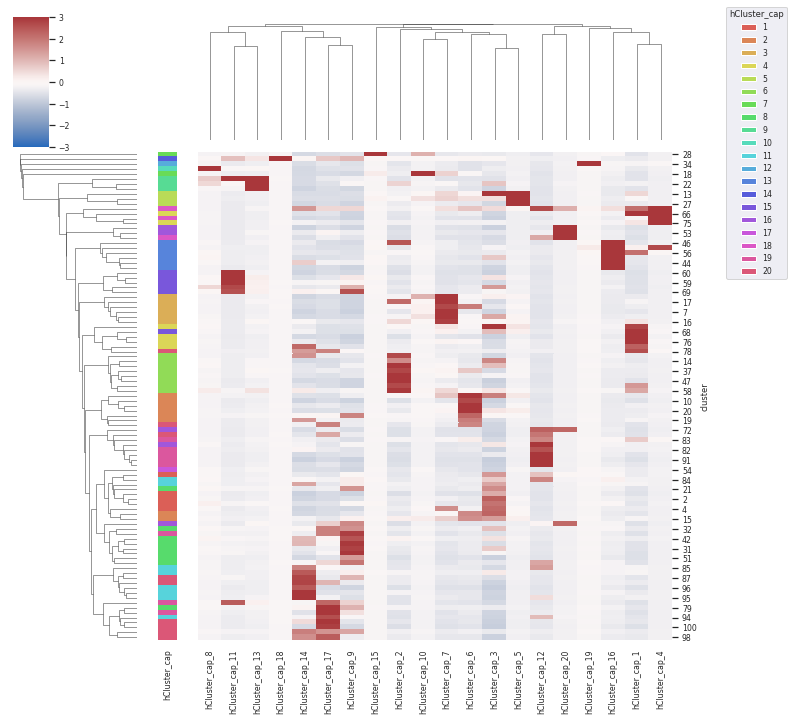

In [30]:
# visualize the average number of pixel clusters per cell SOM cluster (z-scored)
visualize.draw_heatmap(
    data=stats.zscore(cell_cluster_avgs_and_counts[cluster_cols].values),
    x_labels=cell_cluster_avgs_and_counts['cluster'],
    y_labels=cluster_cols,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=hCluster_cap_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='hCluster_cap',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.4: number of cells per meta cluster

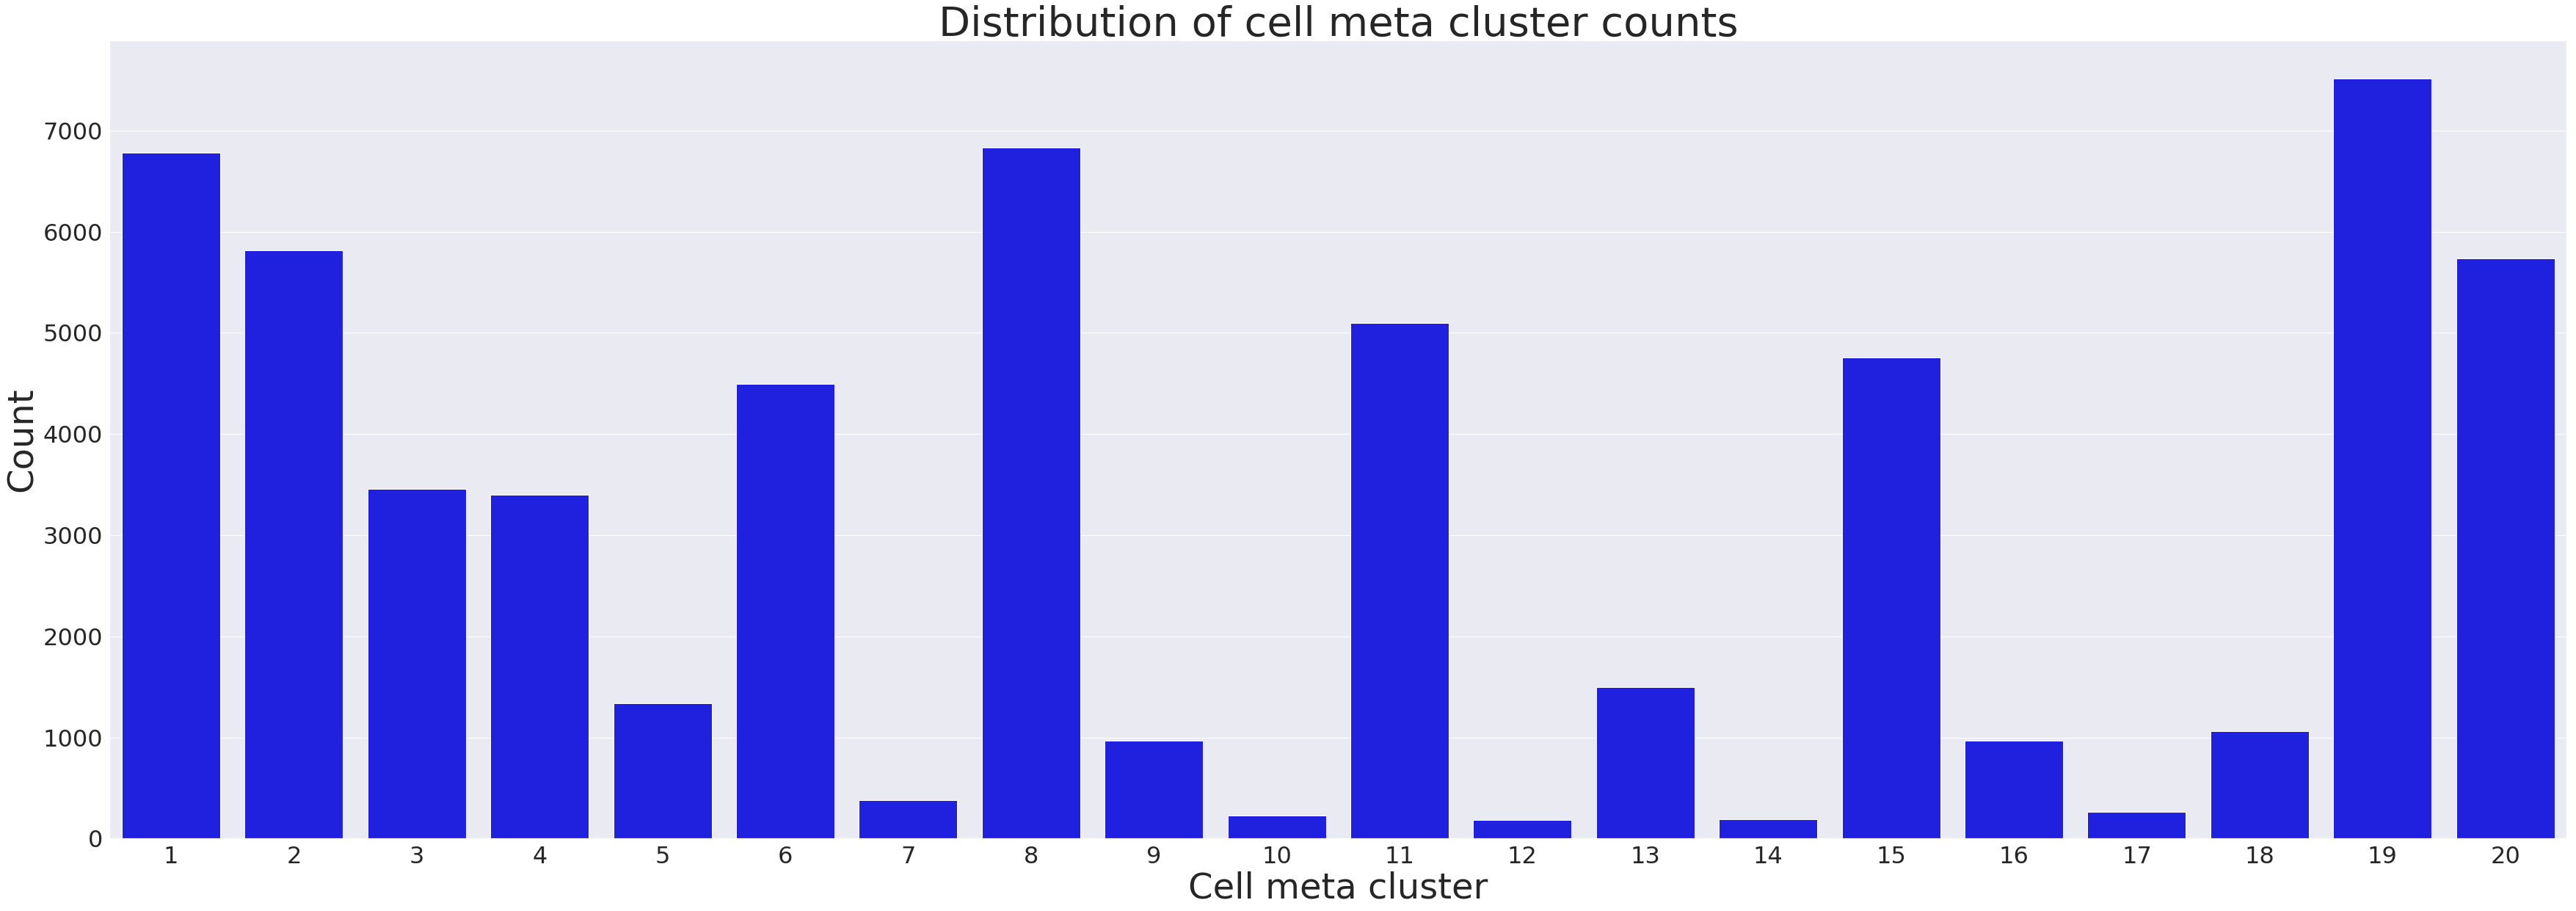

In [31]:
# visualize the cell counts per meta cluster in a barchart
_ = plt.figure(figsize=(60, 20))
# _ = sns.barplot(x=cell_meta_counts['hCluster_cap'], y=cell_meta_counts['count'], palette=['#0000FF' for i in range(cell_meta_counts.shape[0])])
_ = sns.barplot(
    x=cell_hCluster_cap_avgs_and_counts['hCluster_cap'],
    y=cell_hCluster_cap_avgs_and_counts['count'],
    palette=['#0000FF' for i in range(cell_hCluster_cap_avgs_and_counts.shape[0])]
)
_ = plt.title('Distribution of cell meta cluster counts', fontsize=56)
_ = plt.xlabel('Cell meta cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### 3.5: weighted cell meta cluster average heatmap over channels (z-scored)

In [ ]:
# define the colormap
hCluster_cap_labels = cell_hCluster_cap_channel_avg['hCluster_cap'].unique()
color_palette = sns.color_palette("hls", len(hCluster_cap_labels))
colormap = dict(zip(hCluster_cap_labels, color_palette))

# map the values, then reindex based on hCluster_cap values
hCluster_cap_index = cell_hCluster_cap_channel_avg['hCluster_cap'].values
hCluster_cap_mapping = pd.Series(cell_hCluster_cap_channel_avg['hCluster_cap']).map(colormap)
hCluster_cap_mapping.index = hCluster_cap_index

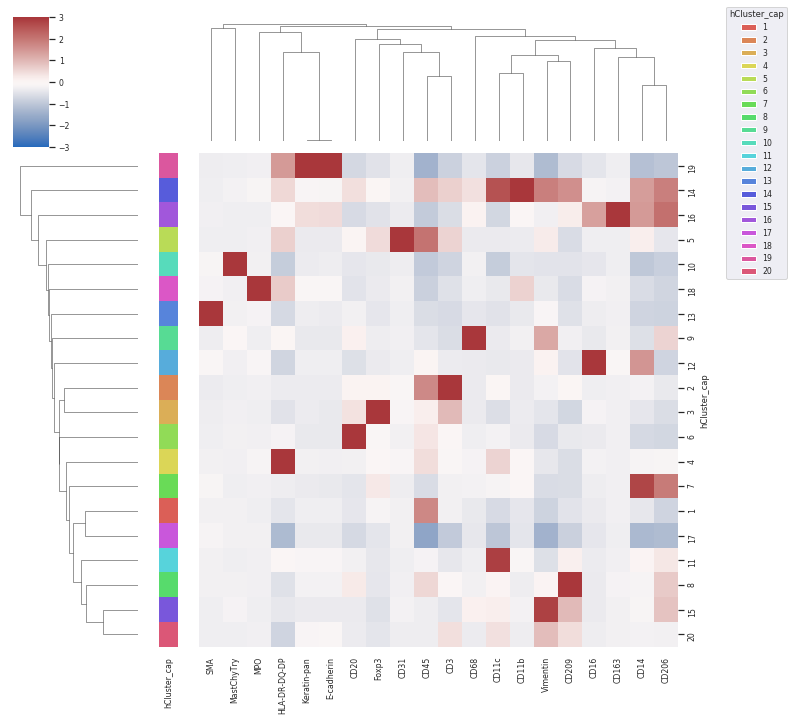

In [33]:
# visualize the cell meta cluster weighted average heatmap over channels (z-scored)
# using weighted average discretizes values better since we take advantage of pixel cluster info
visualize.draw_heatmap(
    data=cell_hCluster_cap_channel_avg.drop(columns='hCluster_cap').values,
    x_labels=cell_hCluster_cap_channel_avg['hCluster_cap'],
    y_labels=cell_hCluster_cap_channel_avg.drop(columns='hCluster_cap').columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=hCluster_cap_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='hCluster_cap',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.6: average number of pixel clusters per cell meta cluster (z-scored)

In [ ]:
# define the colormap, can use scheme defined in 3.5
# map the values, then reindex based on hCluster_cap values
hCluster_cap_index = cell_hCluster_cap_avgs_and_counts['hCluster_cap'].values
hCluster_cap_mapping = pd.Series(cell_hCluster_cap_avgs_and_counts['hCluster_cap']).map(colormap)
hCluster_cap_mapping.index = hCluster_cap_index

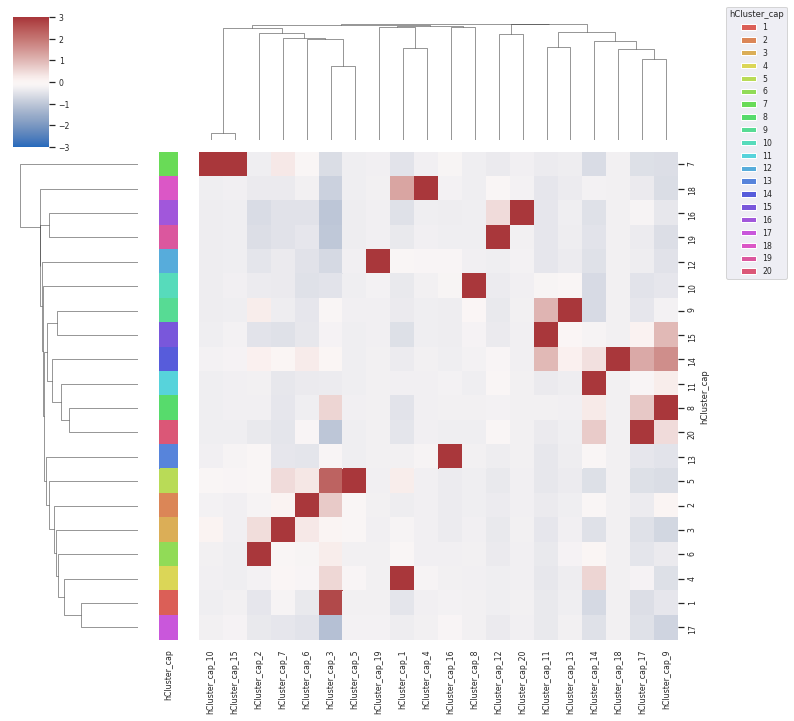

In [35]:
# visualize the average number of pixel clusters per cell SOM cluster (z-scored)
visualize.draw_heatmap(
    data=stats.zscore(cell_hCluster_cap_avgs_and_counts[cluster_cols].values),
    x_labels=cell_hCluster_cap_avgs_and_counts['hCluster_cap'],
    y_labels=cluster_cols,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=hCluster_cap_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='hCluster_cap',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.7: cell cluster overlay

In [ ]:
# select fovs to display
cell_fovs = ['fov6', 'fov7']

In [ ]:
# generate the cell cluster masks for each fov in cell_fovs
cell_cluster_masks = data_utils.generate_cell_cluster_mask(
    cell_fovs,
    base_dir,
    segmentation_dir,
    cell_consensus_name=cell_consensus_name,
    cluster_col='hCluster_cap'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_cell_mask.tiff` in `base_dir`

In [ ]:
save_cell_masks = False

if save_cell_masks:
    data_utils.save_fov_images(
        cell_fovs,
        base_dir,
        cell_cluster_masks,
        name_suffix='_cell_mask'
    )

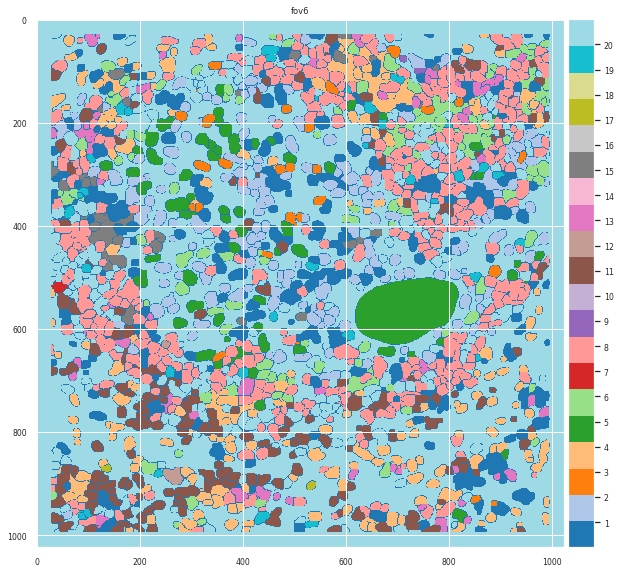

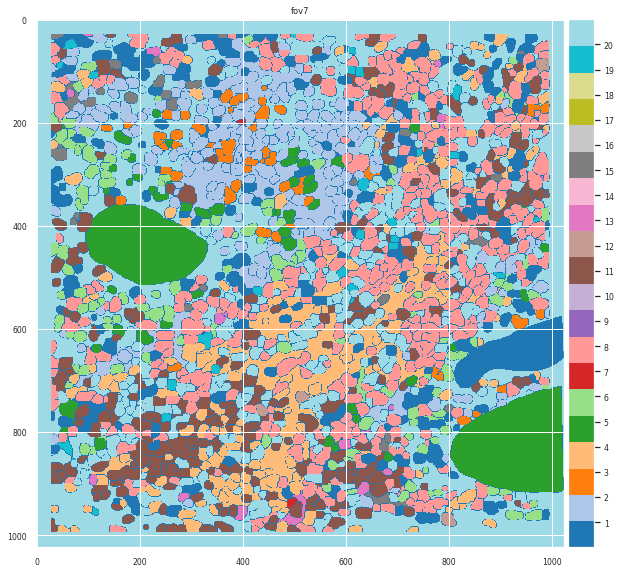

In [39]:
plot_utils.plot_clustering_result(
    cell_cluster_masks,
    cell_fovs,
    tick_range=np.arange(20) + 1
)